## NOTEBOOK : CORRIDORS
THIS NOTEBOOK GENERATES THE PLOTS FOR THE ARTICLE

Paul Peyret - 2022-12-03

In [54]:
# 
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import seaborn as sns
from datetime import datetime
#from mytoolbox import plot_daytime_map, calc_daytime_map
import mytoolbox as mytoolbox
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


from scipy.stats import pearsonr
def calculate_pvalues(df):
    if isinstance(df, pd.DataFrame) == False:
        raise TypeError("df must be a Pandas Dataframe")
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notna() & df[c].notna()]
            pvalues[r][c] = round(pearsonr(tmp[r], tmp[c])[1], 4)
    return pvalues

Read dataframe from csv file previously calculated, clean and format the table

In [55]:

# Read dataframe
df=pd.read_csv("df_indices_full.csv")
fileformat='%Y%m%d_%H%M%S.WAV' # retrieve datetime ofrmat
df['Date']=df["filename"].apply(lambda x: datetime.strptime(x, fileformat))
df['Time'] = df['Date'].dt.strftime('%H:%M')
df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'],inplace=True) # drop useless comlumns
df['hour']=df['Date'].dt.hour
df['hourstr']=df['hour'].astype(str)
df['hourstr']=df['hourstr'].str.zfill(2)+'h' # add zeros to get double digits hours and h
df['isloud']=df['LEQf']>60
df.set_index(['Date'],inplace=True)
df.head()

df['recpos'] = df['recpos'].astype('category')
df['recpos']=df['recpos'].cat.as_ordered()
df['recpos']=df["recpos"].cat.reorder_categories(["CH9", "CH10", "CH11","CH12"],ordered=True)


# directory where to save the plots
outdir='out_plot_article/' # your output directory name

## set plot facecolor
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

/var/folders/1s/jdmr80cj7ys6qw033qr4xvph0000gn/T/ipykernel_79418/166322070.py:2: DtypeWarning: Columns (74,75,76,77,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("df_indices_full.csv")


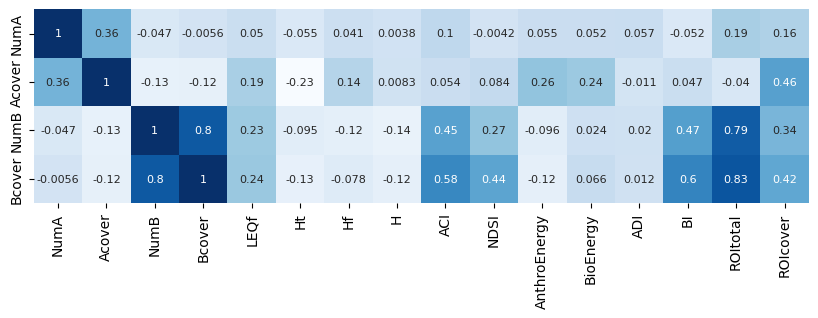

In [3]:
# Correlation plot between annotations and indices
annotated_day="2021-03-29"

Features_short=['NumA', 'Acover','NumB', 'Bcover','LEQf', 'Ht','Hf','H', 'ACI', 'NDSI', 
       'AnthroEnergy', 'BioEnergy','ADI','BI',
       'ROItotal', 'ROIcover']

df_small=df.loc[annotated_day]
df_small=df_small[df_small.Done==True] # select only anotated data
matcorr=df_small[Features_short].corr() # calculate correlaton
matcorr=matcorr[['NumA','Acover','NumB','Bcover']].transpose() # subset of correlation

matp=calculate_pvalues(df_small[Features_short])
matp=matp[['NumA','Acover','NumB','Bcover']].transpose() # subset of pvalue

# Plot maxtrix
fig, ax1 = plt.subplots(1, 1, figsize=[10,5],facecolor='white',sharey=True)

heatmap1 = sns.heatmap(data=matcorr, annot=True, cmap="Blues",square=True,annot_kws={"fontsize":8},ax=ax1,cbar=False)

ax1.tick_params(axis='both', colors='black')

if not outdir == "":
       fig.savefig(outdir+"index_corr_matrix.png")
       


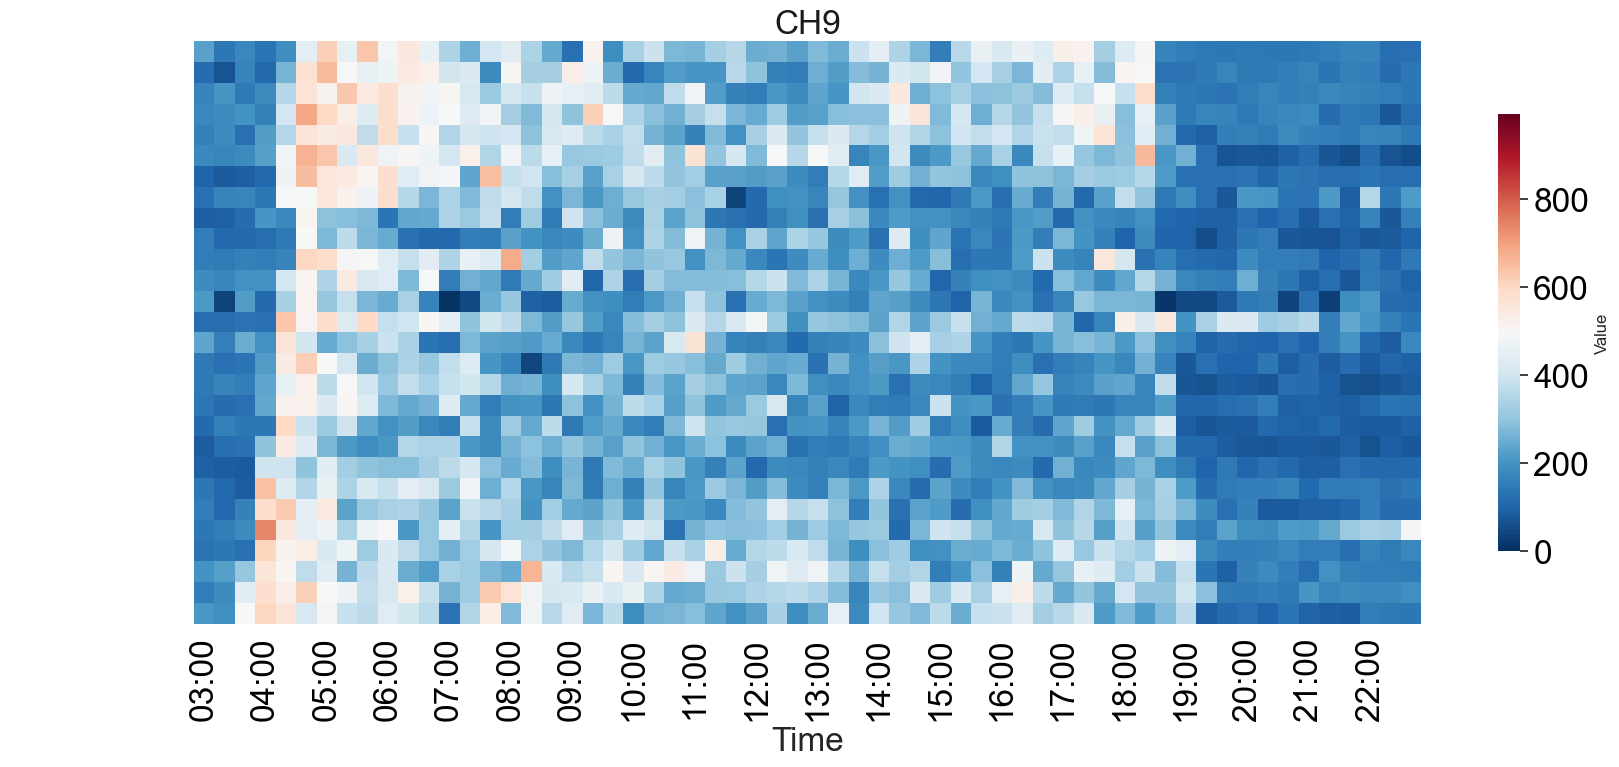

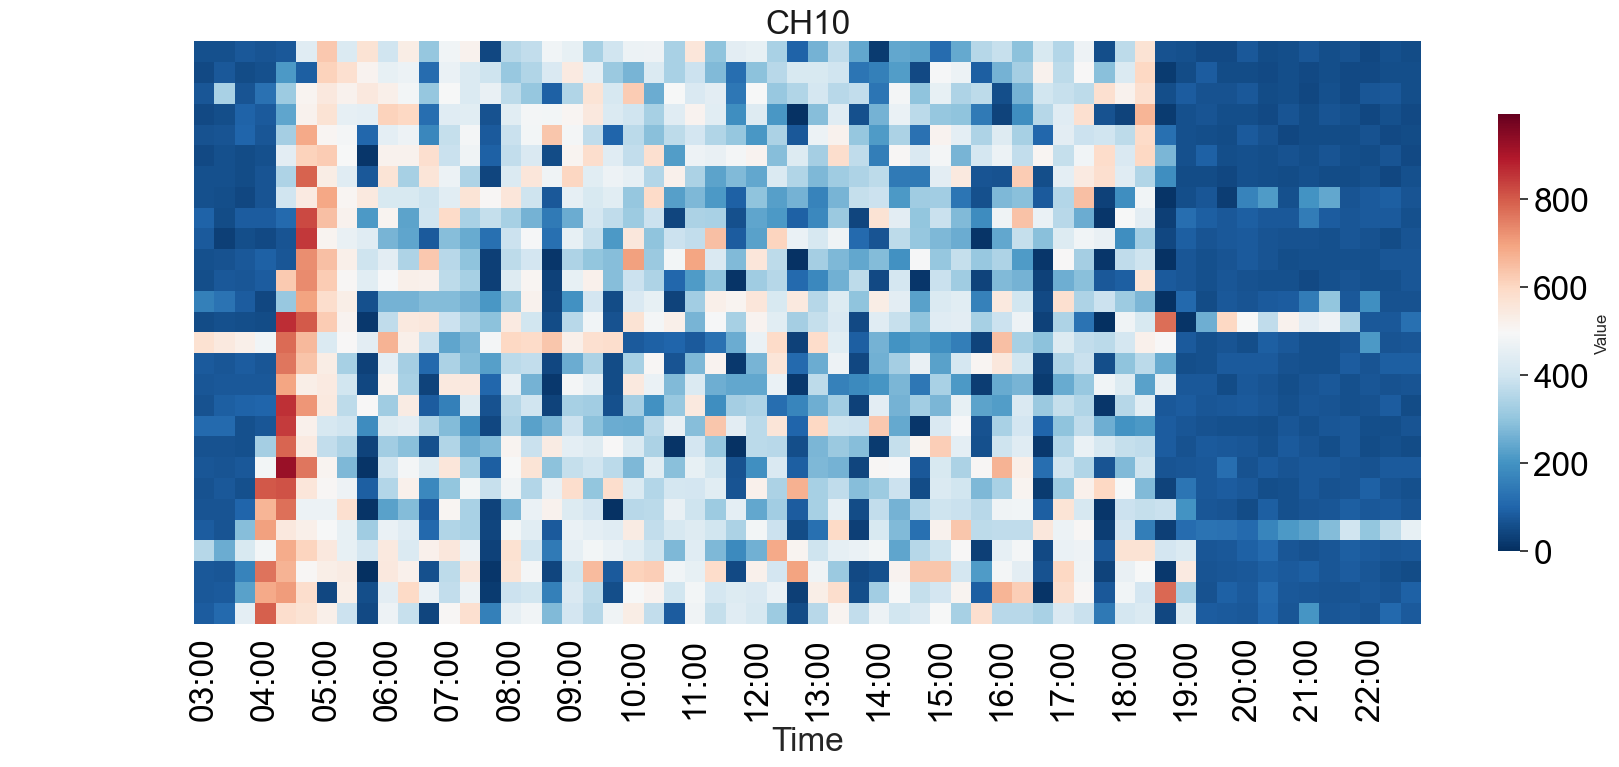

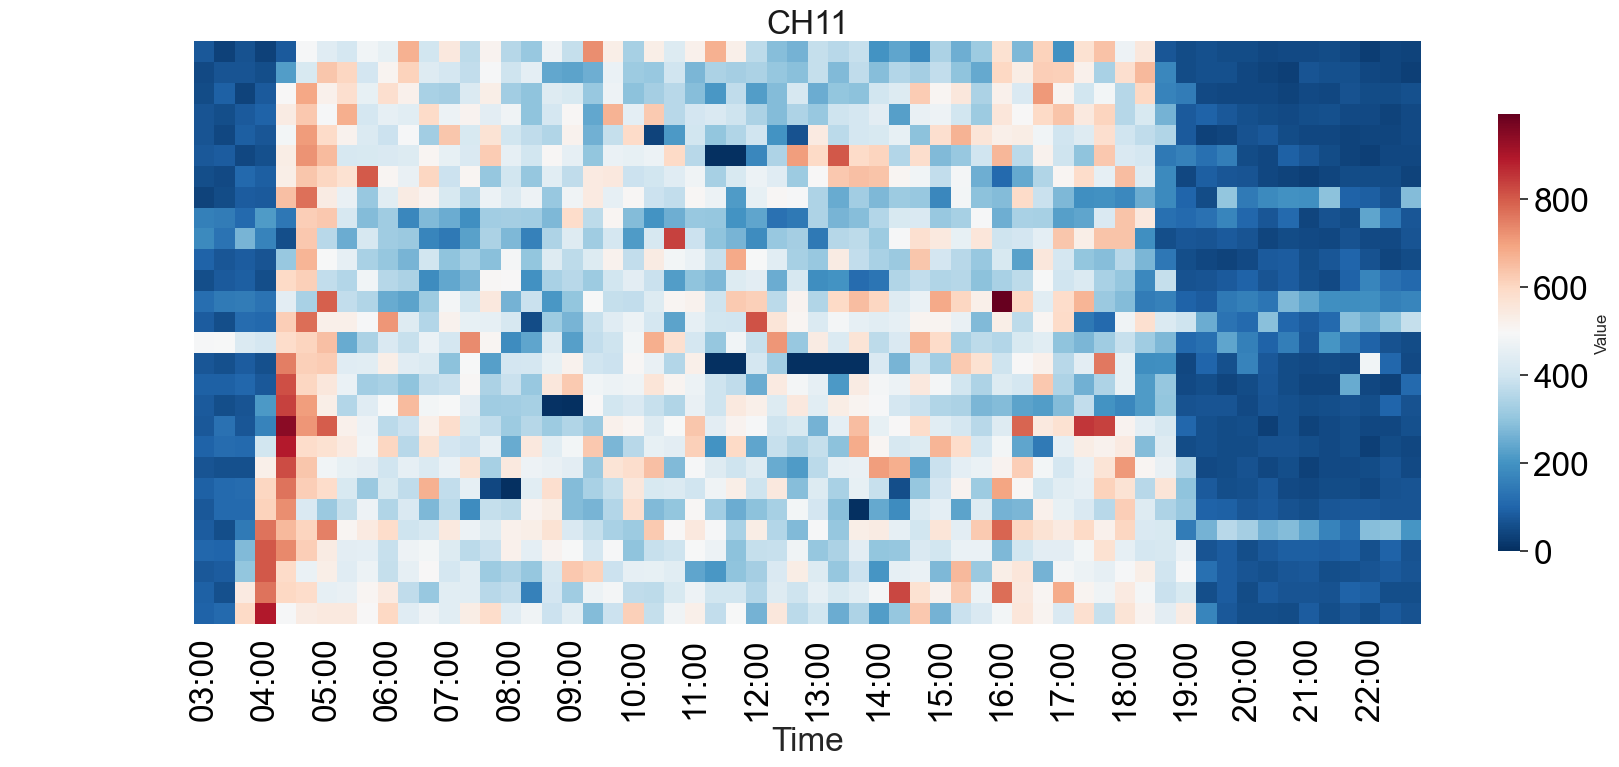

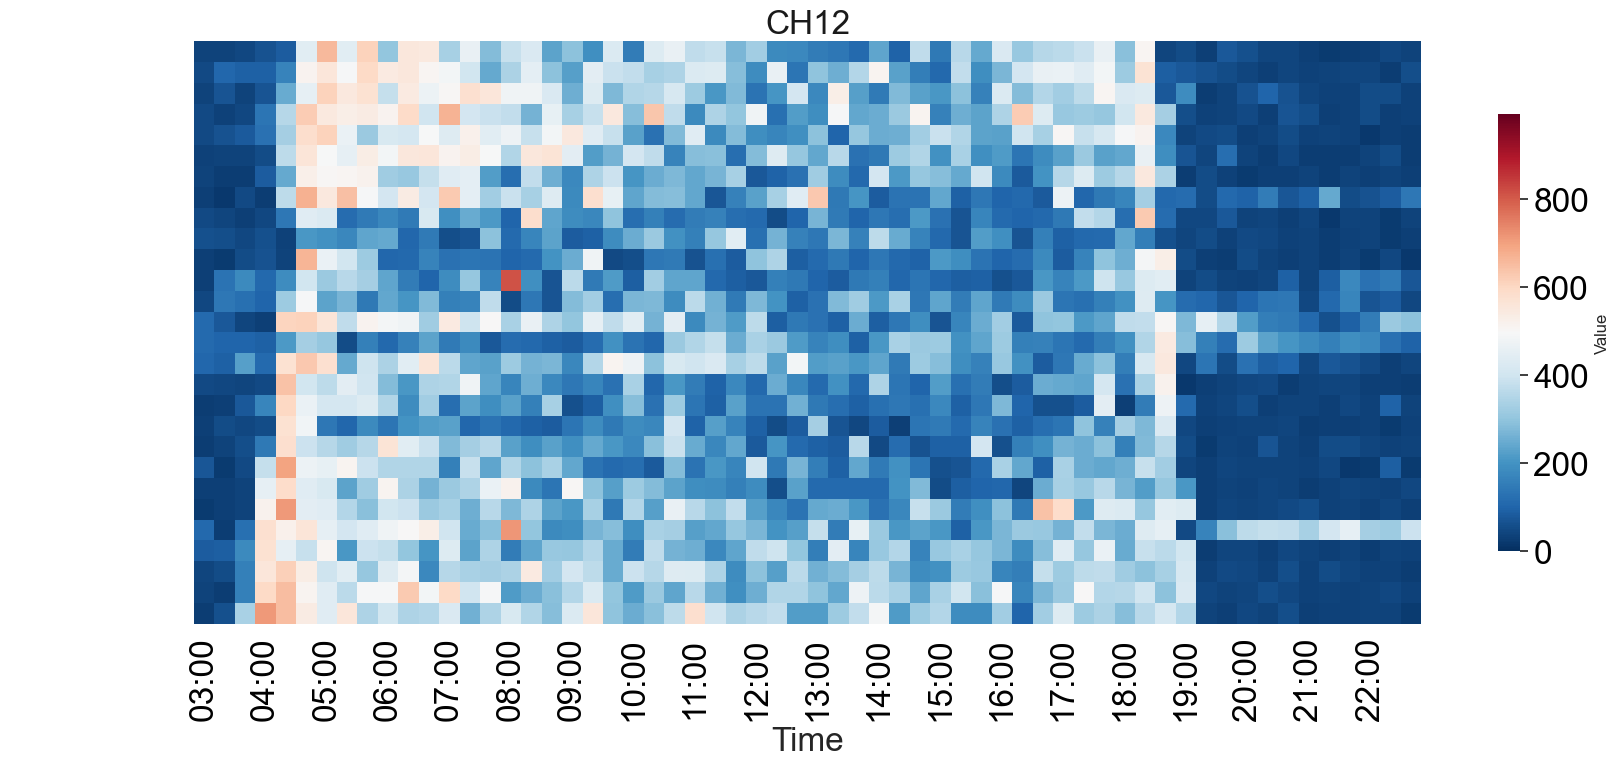

In [56]:
# Plot daytime map
''' ===================USER INPUT=================='''
# ================= user input ===============
usefull_dates=["2021-03-29","2021-04-27"] # P1=["2021-03-26","2021-04-27"] P2=["2021-07-28","2021-08-26"]
sel_recopos=["CH9","CH10","CH11","CH12"]#["CH9","CH10","CH11","CH12"]
time_sample_per_hour=3 # Integer (there is maximum 6 samples per hour)
indexName='ROItotal' # Name of the index to plot
flag_norain=False # if True, dataframe will drop rows with rain
# ===============end user input ==============
plt.rcParams['axes.grid'] = False

vmin=df[(df.index >= usefull_dates[0])& (df.index <= usefull_dates[1])][indexName].min()
vmax=df[(df.index >= usefull_dates[0])& (df.index <= usefull_dates[1])][indexName].max()

for recpos in sel_recopos:
    dftmp=df[df['recpos']==recpos]
    dftmp=dftmp.iloc[::int(6/time_sample_per_hour), :]
    dftmp=dftmp[(dftmp.index >= usefull_dates[0])& (dftmp.index <= usefull_dates[1])]
    df_daily=mytoolbox.calc_daytime_map(dftmp,indexName)
    
    #fig,ax = plt.subplots(1, 1, sharey=True,facecolor='white',
    #                    figsize=(len(df_daily)*0.33, len(list(df_daily))*0.27))
    #-----------------------
    #caxes = ax.imshow(df_daily.transpose(), cmap="RdBu_r", aspect="auto")
    #caxes.set_clim(0, 1200)
    #fig.colorbar(caxes, shrink=0.75, label="Value")    
    # Set ticks on both sides of axes on
    #ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
    # We want to show all ticks...
    #ax.set_yticks(np.arange(len(df_daily.columns)))
    #ax.set_xticks(np.arange(len(df_daily.index)))
    #ax.set_title(indexName)
    # ... and label them with the respective list entries
    #ax.set_yticklabels(df_daily.columns)
    #ax.set_xticklabels(df_daily.index)
    # Rotate the tick labels and set their alignment.
    #plt.setp(ax.get_yticklabels(), rotation=0, ha="right", fontsize=10)
    #plt.setp(ax.get_xticklabels(), rotation=90, ha="center", fontsize=10)
    #_---------------------------
    

    
    fig,ax = plt.subplots(1, 1, sharey=True,facecolor='white',
                        figsize=(len(df_daily)*0.33, len(list(df_daily))*0.27))
    sns.heatmap(df_daily.transpose(),ax=ax,cmap="RdBu_r",vmin=vmin,vmax=vmax,
                cbar_kws={'shrink':0.75, 'label':"Value"})
    
    ax.tick_params(axis='both', colors='black',labelsize=24)
    ax.tick_params(axis='y', colors='white')
    ax.set_title(label=recpos,color='k',fontsize=24)
    #for im in ax.axes.get_images():
    #    im.set_clim(0, 0.5)
        
    cbar = fig.axes[1]
    cbar_yticks = plt.getp(cbar.axes, 'yticklabels')
    #cbar.dataLim=[0,1200]
    plt.setp(cbar_yticks, color='black',fontsize=24)
    #ax.set_zlim(indexName,0,1200)

    fig.set_facecolor('white')
    ax.grid(False)
    ticks=ax.get_xticks()
    ax.set_xticks(ticks[0::3],minor=False)
    ax.set_xlabel(xlabel='Time',fontsize=24)


#%% =============Plot feature day time map ==========
    if not outdir == "":
        fig.savefig(outdir+indexName+'_'+"daytimeMap"+'_'+recpos+'_'.join(usefull_dates)+'.png',bbox_inches = 'tight')


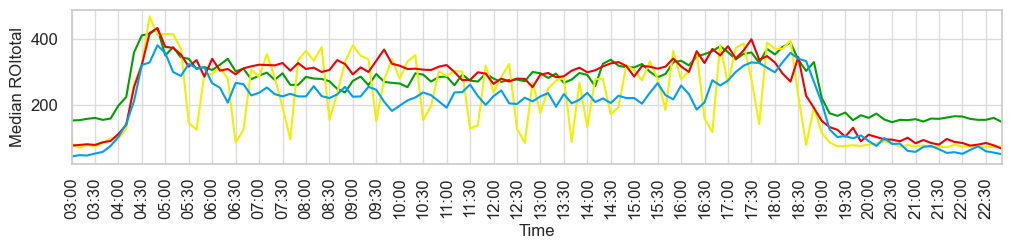

In [57]:
# Plot indicator median vs time
sns.set_theme(context='notebook',style="whitegrid")
fig,ax1 = plt.subplots(1, 1,figsize=[12,2],facecolor='white')
time_sample_per_hour=6
dftmp=df
df1=dftmp[dftmp['recpos']=='CH9'].iloc[::int(6/time_sample_per_hour), :].groupby(by='Time').median()
df2=dftmp[dftmp['recpos']=='CH10'].iloc[::int(6/time_sample_per_hour), :].groupby(by='Time').median()
df3=dftmp[dftmp['recpos']=='CH11'].iloc[::int(6/time_sample_per_hour), :].groupby(by='Time').median()
df4=dftmp[dftmp['recpos']=='CH12'].iloc[::int(6/time_sample_per_hour), :].groupby(by='Time').median()
sns.lineplot(df1,x='Time',y=indexName,ax=ax1,color="#00A000")
sns.lineplot(df2,x='Time',y=indexName,ax=ax1,color="#F0F000")
sns.lineplot(df3,x='Time',y=indexName,ax=ax1,color="#F00000")
sns.lineplot(df4,x='Time',y=indexName,ax=ax1,color="#00A0F0")
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
ax1.tick_params(axis='both', color='k',labelsize=12)
ax1.set_facecolor("white")
ax1.grid(axis='both',color='gainsboro')
ticks=ax1.get_xticks()
ax1.set_xticks(ticks[0::3])
ax1.set_ylabel(ylabel='Median '+indexName)
ax1.set_xlim([min(ticks),max(ticks)])

if not outdir == "":
    fig.savefig(outdir+indexName+'_'+"temporalplot"+'_'.join(usefull_dates)+'.png',bbox_inches = 'tight')
#sns.lineplot(data=df[df.recpos==''],x='Time',y='ROItotal')

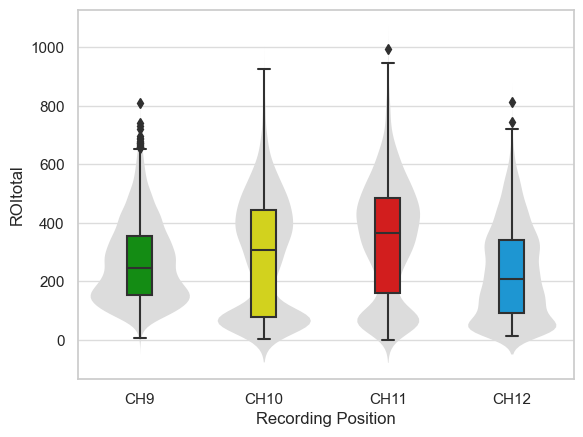

In [52]:
# Violin plot of index in different habitats
usefull_dates=["2021-03-26","2021-04-27"] # P1=["2021-03-26","2021-04-27"] P2=["2021-07-28","2021-08-26"]

dfv=df[(df.index >= usefull_dates[0])& (df.index <= usefull_dates[1])]

#my_pal = {"CH9": "r", "CH10": "orange", "CH11": "yellow","CH12": "green"}
my_colors=["#00A000","#F0F000","#F00000","#00A0F0"]
#%% =============Plot===============
fig,ax1 = plt.subplots(1, 1, sharey=True,facecolor='white')
sns.set_style("whitegrid")
sns.violinplot(data=dfv, x='recpos', y=indexName, color="gainsboro", inner=None, linewidth=0, saturation=0.5,ax=ax1)
sns.boxplot(data=dfv,x='recpos',y=indexName,boxprops={'zorder': 2},ax=ax1,palette=my_colors,width=0.2) #boxplots)
ax1.set_xlabel('Recording Position')
ax1.grid(axis='y',color='gainsboro')

if not outdir == "":
    fig.savefig(outdir+indexName+'_'+"volinplot"+'_'.join(usefull_dates)+'.png')


In [51]:
# STATISTICS
import scipy.stats as stats
from itertools import combinations

sel_recopos=['CH9','CH10','CH11','CH12']
combi=list(combinations(sel_recopos,2))
df_test=df[['recpos',indexName]]
print('\nMann Whitney U test (Wilcoxon rank sum test)')
print(indexName)
for c in combi:
    print('Comparing '+c[0]+' and '+c[1])
    dfx1=df_test[df_test['recpos']==c[0]]
    dfy1=df_test[df_test['recpos']==c[1]]
    # perform two-sided test. You can use 'greater' or 'less' for one-sided test
    Statvalue,p=stats.mannwhitneyu(x=dfx1[indexName], y=dfy1[indexName], alternative = 'two-sided')
    print(f"Stat = {Statvalue:.1f} \t p = {p}")
    # output


Mann Whitney U test (Wilcoxon rank sum test)
ROItotal
Comparing CH9 and CH10
Stat = 29915997.0 	 p = 1.417700079825359e-88
Comparing CH9 and CH11
Stat = 26678653.5 	 p = 3.092395576954305e-11
Comparing CH9 and CH12
Stat = 30779370.5 	 p = 3.833509466522995e-122
Comparing CH10 and CH11
Stat = 21763166.0 	 p = 6.161342781487166e-42
Comparing CH10 and CH12
Stat = 25076150.5 	 p = 0.9575364455335722
Comparing CH11 and CH12
Stat = 28904325.0 	 p = 3.466224160546669e-56


In [8]:
# PLOT UMAP
import umap
import umap.plot  # pip install "umap-learn[plot]"
from babyplots import Babyplot
from sklearn.preprocessing import QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline


ALL_FEATURES=['MEANf','VARf','SKEWf','KURTf','NBPEAKS','LEQf',
'ENRf','BGNf','SNRf','Hf', 'EAS','ECU','ECV','EPS_KURT','EPS_SKEW','ACI',
'NDSI','rBA','AnthroEnergy','BioEnergy','BI','ROU','ADI','AEI','LFC','MFC','HFC',
'ACTspFract','ACTspCount','ACTspMean', 'EVNspFract','EVNspMean','EVNspCount',
'TFSD','H_Havrda','H_Renyi','H_pairedShannon', 'H_gamma', 'H_GiniSimpson','RAOQ',
'AGI','ROItotal','ROIcover','ZCR','MEANt', 'VARt', 'SKEWt', 'KURTt',
'LEQt','BGNt', 'SNRt','MED', 'Ht','H','ACTtFraction', 'ACTtCount','EVNtFraction', 'EVNtMean', 'EVNtCount']


#----------- USER INPUT------------
usefull_dates=["2021-03-26","2021-04-27"] # P1=["2021-03-26","2021-04-27"] P2=["2021-07-28","2021-08-26"]
sel_recopos=["CH9","CH10","CH11","CH12"]#["CH9"] # ["CH9","CH10","CH11","CH12"]

Ndim_umap=2 # Number of dimensions for the UMAP
n_neighbors_umap=15# Number of neighbors for UMAP
random_seed=42 # Random seed for UMAP
FEATURES=ALL_FEATURES # All features or a subset ALL_FEATURES or SHORT_FEATURES
#----------------------------------

# Compute the subset of dates and recpos
dfu=df[df['recpos'].isin(sel_recopos)]
dfu=dfu[((dfu.index >= usefull_dates[0]) & (dfu.index <= usefull_dates[1]))]
#df=df[(df.index.hour>=3) & (df.index.hour=<6)]

X=dfu[ALL_FEATURES].to_numpy()

# ==================== PROCESSING UMAP=======================
# Preprocess with a quantile transformer
pipe = make_pipeline(SimpleImputer(strategy="mean"), QuantileTransformer())
X = pipe.fit_transform(X.copy())

# Fit UMAP to processed data
manifold = umap.UMAP(random_state=random_seed,n_neighbors=n_neighbors_umap,n_components=Ndim_umap).fit(X)
X_reduced = manifold.transform(X)
#dfu['xred']=X_reduced[:,0]
#dfu['yred']=X_reduced[:,1]

/Users/paul/Dev/Projects/corridors/.venvcorr/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


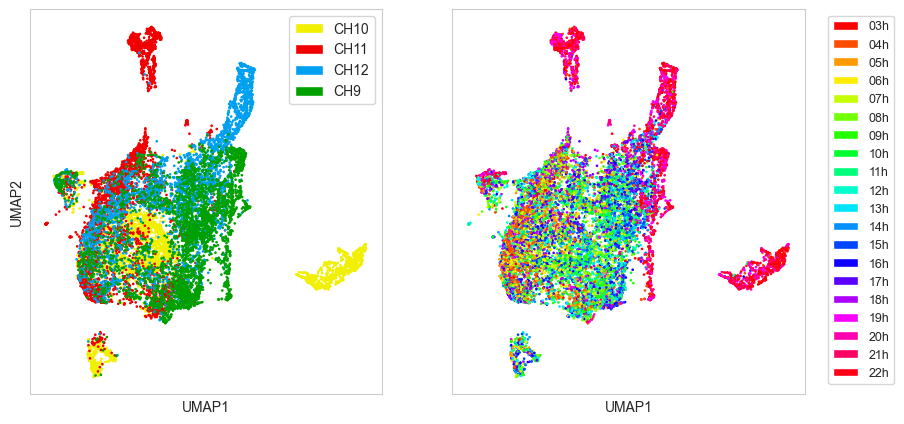

In [16]:
# ================== PLOT UMAP ====================
umap_label_by='recpos' # 'recpos' 'israining' 'hourstr' 'labelsdbscan' 'isloud'
mycolorscale="hsv"

my_colors=["#F0F000","#F00000","#00A0F0","#00A000"]

if Ndim_umap==2:  # Use UMAP.plot
    fig,(ax1,ax2) = plt.subplots(1, 2, sharey=True,figsize=[10,5],facecolor='white')
    fig.patch.set_facecolor('white')

    #labelbb=dfu[umap_label_by].to_numpy().tolist() # labels
    #sns.scatterplot(dfu,ax=ax1,hue=labelbb,colors=mycolorscale)


    umap.plot.points(manifold, labels=dfu[umap_label_by],color_key=my_colors,ax=ax1,background="white")
    
    umap.plot.points(manifold, labels=dfu['hourstr'],color_key_cmap='hsv',ax=ax2,background="white")
    
    unique_labels = np.unique(dfu['hourstr'])
    num_labels = unique_labels.shape[0]
    color_key = plt.get_cmap('hsv')(np.linspace(0, 1, num_labels))
    legend_elements = [Patch(facecolor=color_key[i], label=unique_labels[i])
            for i, k in enumerate(unique_labels)]
    ax2.legend(handles=legend_elements,bbox_to_anchor=(1.05, 1.0), loc='upper left',fontsize=9)
    ax1.set_ylabel('UMAP2')
    ax1.set_xlabel('UMAP1')
    ax2.set_xlabel('UMAP1')


    
    # remove text under plot
    for txt in ax1.texts:
      txt.set_visible(False)
    for txt in ax2.texts:
      txt.set_visible(False)
                
    if not outdir == "":
      fig.savefig(outdir+indexName+'_'+"UMAP"+'_'.join(usefull_dates)+'.png')

elif Ndim_umap==3: # Use babyplot
    outname='UMAP_3D.html'
    labelbb=dfu[umap_label_by].to_numpy().tolist() # labels
    bp=Babyplot()
    bp.add_plot(X_reduced[:,:].tolist(), "pointCloud", "categories",labelbb, {"shape": "sphere",
                                                                 "colorScale": mycolorscale,
                                                                 "showAxes": [True, True, True],
                                                                 "axisLabels": ["UMAP 1", "UMAP 2", "UMAP 3"],
                                                                 "showLegend": True,
                                                                 "fontSize": 12,
                                                                 "labelSize":20})
    
    
    #bp
    bp.save_as_html(outname)





In [53]:
df

period recpos             filename    Year  Month  \
Date                                                                    
2021-03-26 03:00:00     P1   CH10  20210326_030000.WAV  2021.0    3.0   
2021-03-26 03:10:00     P1   CH10  20210326_031000.WAV  2021.0    3.0   
2021-03-26 03:20:00     P1   CH10  20210326_032000.WAV  2021.0    3.0   
2021-03-26 03:30:00     P1   CH10  20210326_033000.WAV  2021.0    3.0   
2021-03-26 03:40:00     P1   CH10  20210326_034000.WAV  2021.0    3.0   
...                    ...    ...                  ...     ...    ...   
2021-08-24 22:10:00     P2    CH9  20210824_221000.WAV  2021.0    8.0   
2021-08-24 22:20:00     P2    CH9  20210824_222000.WAV  2021.0    8.0   
2021-08-24 22:30:00     P2    CH9  20210824_223000.WAV  2021.0    8.0   
2021-08-24 22:40:00     P2    CH9  20210824_224000.WAV  2021.0    8.0   
2021-08-24 22:50:00     P2    CH9  20210824_225000.WAV  2021.0    8.0   

                     Weekday Name           ZCR         MEANt      VARt  \
Date                                                                      
2021-03-26 03:00:00           4.0  18812.216667  1.677863e-19  0.000004   
2021-03-26 03:10:00           4.0  20134.650000 -5.124180e-20  0.000003   
2021-03-26 03:20:00           4.0  19579.016667  8.133926e-21  0.000003   
2021-03-26 03:30:00           4.0  20024.050000  8.360885e-20  0.000003   
2021-03-26 03:40:00           4.0  20086.300000 -8.346911e-20  0.000003   
...                           ...           ...           ...       ...   
2021-08-24 22:10:00           1.0   9670.050000 -1.979271e-19  0.000021   
2021-08-24 22:20:00           1.0   9474.850000  1.680802e-19  0.000022   
2021-08-24 22:30:00           1.0  10510.983333  7.956598e-20  0.000018   
2021-08-24 22:40:00           1.0  10267.316667  1.902413e-20  0.000019   
2021-08-24 22:50:00           1.0   9717.483333  2.543731e-19  0.000021   

                        SKEWt  ...  Comment  NumA  NumB  Acover  Bcover  \
Date                           ...                                        
2021-03-26 03:00:00  0.163909  ...      NaN   NaN   NaN     NaN     NaN   
2021-03-26 03:10:00  0.127630  ...      NaN   NaN   NaN     NaN     NaN   
2021-03-26 03:20:00  0.142164  ...      NaN   NaN   NaN     NaN     NaN   
2021-03-26 03:30:00  0.147285  ...      NaN   NaN   NaN     NaN     NaN   
2021-03-26 03:40:00  0.135931  ...      NaN   NaN   NaN     NaN     NaN   
...                       ...  ...      ...   ...   ...     ...     ...   
2021-08-24 22:10:00  0.006434  ...      NaN   NaN   NaN     NaN     NaN   
2021-08-24 22:20:00 -0.007214  ...      NaN   NaN   NaN     NaN     NaN   
2021-08-24 22:30:00 -0.001904  ...      NaN   NaN   NaN     NaN     NaN   
2021-08-24 22:40:00  0.009245  ...      NaN   NaN   NaN     NaN     NaN   
2021-08-24 22:50:00 -0.001818  ...      NaN   NaN   NaN     NaN     NaN   

                     AcoverProp  BcoverProp  hour  hourstr  isloud  
Date                                                                
2021-03-26 03:00:00         NaN         NaN     3      03h   False  
2021-03-26 03:10:00         NaN         NaN     3      03h   False  
2021-03-26 03:20:00         NaN         NaN     3      03h   False  
2021-03-26 03:30:00         NaN         NaN     3      03h   False  
2021-03-26 03:40:00         NaN         NaN     3      03h   False  
...                         ...         ...   ...      ...     ...  
2021-08-24 22:10:00         NaN         NaN    22      22h   False  
2021-08-24 22:20:00         NaN         NaN    22      22h   False  
2021-08-24 22:30:00         NaN         NaN    22      22h   False  
2021-08-24 22:40:00         NaN         NaN    22      22h   False  
2021-08-24 22:50:00         NaN         NaN    22      22h   False  

[28320 rows x 85 columns]